In [5]:
%matplotlib inline

In [6]:
# We'll use this to draw some graphs.
import networkx as nx

# D-separation and the back-door criterion

Let's build up the intuition for d-separation and the back-door criterion. We'll start with the 3-node graphs with two edges. Here, we'll be working with causal graphs. Remember that d-separation is more general, and applies to all bayesian networks. The causal interpretations of the arrows only apply to causal graphs, and not bayesian networks in general!

## D-separation

We'll start by looking at d-separation, which will be a tool we'll use to cut paths in a graph. By cutting the _right_ paths, we can get causal estimates from statistical data! Let's build the definition by looking at 3-node graphs, and developing intuition.

### Chain Graphs

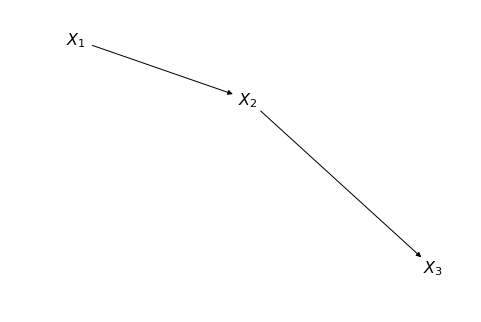

In [99]:
g = nx.DiGraph([('$X_1$', '$X_2$'), ('$X_2$', '$X_3$')])
nx.draw(g, with_labels=True, node_color='w', font_size=16, node_size=1000)

Here, $X_1$ causes $X_2$, which causes $X_3$. This could be, for example, running ($X_1$) causes you to be tired ($X_2$), which causes you to sleep ($X_3$). If I know you're tired, $X_2=1$, then it doesn't matter whether that's from running or something else. You'll have the same propensity to sleep: $P(X_3|X_2, X_1) = P(X_3|X_2)$. 

This relationship is called "conditional independence". It's that "sleep" is independent of "running" conditional on the fact that we know how "tired" you are. More technically, knowing $X_2$, $X_1$ gives us no additional information about $X_3$. We sometimes say that $X_2$ "blocks" the path between $X_3$ and $X_1$.

You can rewrite 

$$P(X_3|X_2, X_1) = P(X_3|X_2)$$

as 

$$P(X_3, X_1|X_2) = P(X_3|X_2) P(X_1|X_2)$$.

This way, it looks much more like statistical independence. Remember $X$ and $Y$ are statistically independent if and only if $P(X,Y) = P(X)P(Y)$. Here, it's independence conditional on $X_2$. We can explore this with a little data. We'll generate some data with the same statistical structure as this graph.

In [92]:
import numpy as np
import pandas as pd

N = 100000

x1 = np.random.binomial(1, p=0.5, size=N)
x2 = np.random.binomial(1, p=0.25 + 0.6 * x1, size=N)
x3 = np.random.binomial(1, p=0.25 + 0.6 * x2, size=N)

df = pd.DataFrame({'$X_1$': x1, '$X_2$': x2, '$X_3$': x3})

First, notice that $X_1$ and $X_3$ are statistically dependent. They have a non-zero correlation!

In [93]:
df[['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,0.362736
$X_3$,0.362736,1.000000


But let's condition on $X_2$, by restricting down to some value of $X_2$.

In [94]:
df_with_x2_0 = df[df['$X_2$'] == 0]
df_with_x2_0[['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,0.000023
$X_3$,0.000023,1.000000


and the correlation goes away! We can do the same thing with $X_2 = 1$. The value doesn't matter. Just knowing the value is what matters.

In [97]:
df_with_x2_1 = df[df['$X_2$'] == 1]
df_with_x2_1[['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,-0.002916
$X_3$,-0.002916,1.000000


Another term for "blocking" is "d-separation". We can say that conditioning on the middle node of a chain _d-separates_ the ends on the chain.

Now, let's look at the other 3-variable, 2-edge graphs. First, the "fork".

### Fork Graphs

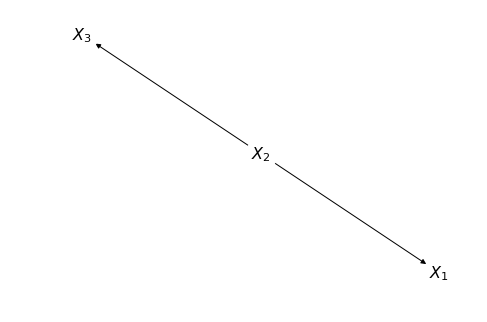

In [101]:
g = nx.DiGraph([('$X_2$', '$X_1$'), ('$X_2$', '$X_3$')])
nx.draw(g, with_labels=True, node_color='w', font_size=16, node_size=1000)

What's a system that might have this structure? An example we used in class was $X_1$ is "a crime was committed today", $X_2$ is "the weather was warm today", and $X_1$ is "a lot of lemonade was sold today". 

In this graph, you'll find that on warm days, more lemonade is sold. On warm days, more crimes are committed (because more people are outside doing things). This common dependence on the weather makes lemonade sales tend to be higher on the same days that crime is more likely. This will result in a correlation between lemonade sales and crime.

From the graph, you can see there's no directed path from $X_1$ to $X_3$ or vice versa. In a sense, these variables don't cause each other. This is a spurious, or non-causal, correlation. There is statistical dependence between $X_1$ and $X_3$, even though there's no causal dependence.

If we restrict our data to only warm days, we should remove the co-variation between $X_1$ and $X_3$ due to the weather. That should render them independent of each other. Let's see if it works. First, let's generate data.

In [102]:
N = 100000

x2 = np.random.binomial(1, p=0.5, size=N)
x1 = np.random.binomial(1, p=0.25 + 0.6 * x2, size=N)
x3 = np.random.binomial(1, p=0.25 + 0.6 * x2, size=N)

df = pd.DataFrame({'$X_1$': x1, '$X_2$': x2, '$X_3$': x3})

Now, let's confirm that $X_1$ and $X_3$ are statistically dependent.

In [105]:
df[['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,0.362382
$X_3$,0.362382,1.000000


There's a nonzero correlation! We've confirmed that there's spurious statistical dependence. Now, let's see if we can get rid of the statistical dependence by conditioning on the weather, $X_2$.

In [106]:
df[df['$X_2$'] == 1][['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.0000,0.0006
$X_3$,0.0006,1.0000


In [107]:
df[df['$X_2$'] == 0][['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,0.007077
$X_3$,0.007077,1.000000


Looks good! We've shown that conditioning on the middle node of a fork will render the ends statistically independent. Now, let's look at the last of the 3-node, 2-edge graphs: the "collider".

### Collider Graphs

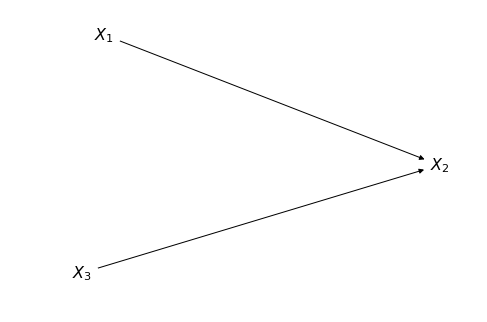

In [108]:
g = nx.DiGraph([('$X_1$', '$X_2$'), ('$X_3$', '$X_2$')])
nx.draw(g, with_labels=True, node_color='w', font_size=16, node_size=1000)

In class, we used the example of $X_1$ is "a person has good math skils", $X_3$ is "a person has good social skills", and $X_2$ is "the person is admitted to college". In this example, math skills and social skills are uncorrelated in the general population. You will only be admitted to college if one skill, the other, or both are good.

In the college population, $X_2 = 1$, we've selected a subset of the general population. While $X_1$ and $X_3$ were uncorrelated in the general population, we're not guaranteed they are in the selected population. 

Consider: If we know someone was admitted to college, $X_2 = 1$, and that they have bad math skills, what must we know about their social skills? Since they were admitted, their social skills must be good. Conditional on admittance to college, knowledge about their math skills has told us something about their social skills. In other words, math and social skills are _conditionally dependent_, given college admittance.

Let's check this with some data.

In [114]:
N = 1000000

x1 = np.random.binomial(1, p=0.5, size=N)
x3 = np.random.binomial(1, p=0.5, size=N)
x2 = np.random.binomial(1, p=0.25 + 0.25 * x1 + 0.25 * x3, size=N)

df = pd.DataFrame({'$X_1$': x1, '$X_2$': x2, '$X_3$': x3})

Let's confirm that these are independent in the general population:

In [115]:
df[['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,0.000585
$X_3$,0.000585,1.000000


and now let's see if they become dependent when we restrict to the admitted (or not) populations.

In [116]:
df[df['$X_2$'] == 1][['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,-0.066144
$X_3$,-0.066144,1.000000


In [117]:
df[df['$X_2$'] == 0][['$X_1$', '$X_3$']].corr()

,$X_1$,$X_3$
$X_1$,1.000000,-0.065696
$X_3$,-0.065696,1.000000


Now there's a small, negative correlation between math and social skills in the admitted and un-admitted populations. $X_1$ and $X_3$ are statistically independent, but they're _conditionally_ dependent.

### Summary and Definition of d-separation

To summarize, we looked at three graphs. In each, we checked whether the ends were statistically dependent, and whether they were conditionally statistically dependent given the middle node. For the chain graph, the ends are statistically dependent, but blocked by conditioning on the middle node. For the fork, the ends are again statistically dependent, but again conditionally independent given the middle node. Finally, for the collider, the ends are statistically independent, but statistically dependent given the middle node. We can summarize all of this into the definition of d-separation. If two nodes on a path are d-separated by some other node, then they will be conditionally independent given that node.

> **Definition: d-separation**
>
> Let $p$ be a path (not necessarily directed) in a DAG $G$ between nodes $X_i$ and $X_j$. Then the path will be "blocked," or the nodes will be "d-separated" by a set of nodes $Z$ if
>
> 1. $p$ contains a chain, $X_l \rightarrow X_k \rightarrow X_m$  or a fork $X_l \leftarrow X_k \rightarrow X_m$ such that the middle node is in $Z$, or
> 2. $p$ contains a collider $X_l \rightarrow X_k \leftarrow X_m$ such that the middle node is _not_ in $Z$, and no descendant of the middle node is in $Z$.

Notice that the path just has to contain these nodes: $X_i$ and $X_j$ don't have to be members of these 3-node pieces!

## The Back-Door Criterion

Now, we can build up to the back-door criterion. The basic intuition is this: directed paths from $X_i$ to $X_j$ lead to causal dependence between $X_i$ and $X_j$. There are two ways to accidentally get non-causal statistical dependence between $X_i$ and $X_j$: confounding paths between $X_i$ and $X_j$, and accidentally conditioning on colliders on paths between $X_i$ and $X_j$. Let's start reasoning from the do() operation.

Consider the causal effect of $X_1$ on $X_3$ in this graph.

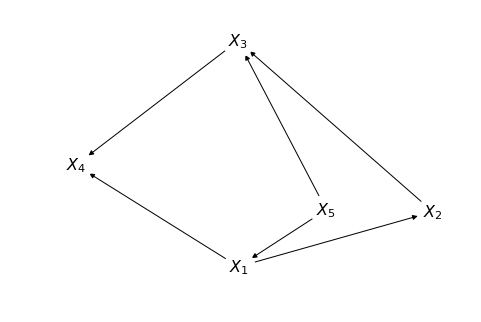

In [141]:
pos = nx.layout.spring_layout(g)
g = nx.DiGraph([('$X_1$', '$X_2$'), ('$X_2$', '$X_3$'),  # a directed path from x1 to x3
                ('$X_1$', '$X_4$'), ('$X_3$', '$X_4$'),  # a collider at x4
                ('$X_5$', '$X_1$'), ('$X_5$', '$X_3$')]) # a fork from x5
nx.draw(g, with_labels=True, node_color='w', font_size=16, node_size=1000, pos=pos)

Consider the graph we get if we want to $do(X_1=x_1)$. The procedure is to cut all edges going into $X_1$ (i.e. disrupt its usual causes), force all children of $X_1$ to take the value $X_1 = x_1$, and assume the other conditional distributions are un-disrupted. That gives us the new graph where we cut the edges going into $X_1$, and leave the rest of the graph untouched.

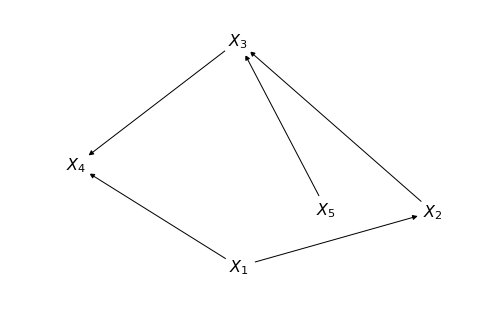

In [142]:
g = nx.DiGraph([('$X_1$', '$X_2$'), ('$X_2$', '$X_3$'),  # a directed path from x1 to x3
                ('$X_1$', '$X_4$'), ('$X_3$', '$X_4$'),  # a collider at x4
                ('$X_5$', '$X_3$')]) # no longer a fork from x5, we cut ('$X_5$', '$X_1$'),
nx.draw(g, with_labels=True, node_color='w', font_size=16, node_size=1000, pos=pos)

In this new graph, which paths are distrupted? From the do() operation, it's any path with an arrow into $X_1$. Here, that's the fork! Notice that the collider leads to no statistical dependence between $X_1$ and $X_3$. The only remaining statistical dependence is due to the directed path from $X_1$ to $X_3$.

Now, let's relate this with d-separation. This operation is a model for what an intervention looks like in the world. We say we distrupt the causes of $X_1$, leave everything else alone, and study the statistics of the new system. If we can't do that, we can have the same effect by disrupting the same paths. In other words, if we can block the path $X_1 \leftarrow X_5 \rightarrow X_3$ in our observational data, we can still compute the same statistics (e.g. conditional distributions) that we would in an experiment! We can summarize this reasoning in a rule for which paths you should cut.

> **Definition: The Back-Door Criterion**
>
> A set of variables $Z$ satisfies the _back-door criterion_ relative to an ordered pair of variables $(X_i, X_j)$ in a DAG $G$ if:
> 1. no node in $Z$ is a descendant of $X_i$, and 
> 2. $Z$ blocks every path between $X_i$ and $X_j$ that contains an arrow into $X_i$.
>
> Similarly, if $X$ and $Y$ are two disjoint subsets of nodes in $G$, then $Z$ is said to satisfy the back-door criterion relative to any pair $(X, Y)$ if it satisfies the criterion relative to any pair $(X_i, X_j)$ such that $X_i \in X$ and $X_j \in Y$.

The first condition of the criterion keeps us from conditioning on nodes that fall along directed paths. It also keeps us from conditioning on colliders, or descendants of colliders.

The second condition makes sure we block all confounding paths between $X_i$ and $X_j$. 

All that remains is causal statistical dependence. 

Now, how do we estimate quantities like $P(Y|X)$ in a experimental study, given our observational data? We'll label the experimental version of this $P(Y|do(X=x))$, and the observational version of this quanitity $P(Y|X)$. Then, the answer is given by the formula:

> **Theorem: Back Door Adjustment**
>
> If a set of variables $Z$ satisfies the back-door criterion relative to $(X, Y)$, then the causal effect of $X$ on $Y$ is identifiable, and is given by the formula 
>
> $$ P(Y|do(X=x)) = \sum_Z P(Y|X=x, Z=z)P(Z=z)$$
>

The first factor inside the sum is $P(Y|X)$ conditional also on $Z$. The reason we have to do the extra conditioning is so that we block the noncausal association between $X$ and $Y$, and we're only left with the causal part. In other words, $P(Y|X, Z) = P(Y|do(X),Z)$. Then, we want to get rid of the extra $Z$ part, which we don't really care about. We can do that by averaging over the $Z$. Hence, we multiply by $P(Z)$ and sum over $Z$.